# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [4]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 8

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X, y = generate_data(3000)

print(f"Data Generated: {X.shape} samples.")
print(f"Target Generated: {y.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [5]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================


# Init Weights


In [9]:
# --- 1. Split Data into Train (70%) and Validation (30%) ---
# Shuffle indices first to ensure random split
indices = torch.randperm(len(X))
split = int(0.7 * len(X))

# Create the sets
X_train = X[indices[:split]]
y_train = y[indices[:split]]

X_val = X[indices[split:]]
y_val = y[indices[split:]]

# --- 2. Initialize Weights and Biases ---
# We use He Initialization because we are using ReLU
def init_param(n_in, n_out):
    std = np.sqrt(2.0 / n_in)
    w = (torch.randn(n_in, n_out) * std).requires_grad_(True)
    b = torch.zeros(1, n_out, requires_grad=True)
    return w, b

# Architecture: Input(2) -> 16 -> 16 -> 16 -> Output(1)
w1, b1 = init_param(2, 16)
w2, b2 = init_param(16, 16)
w3, b3 = init_param(16, 16)
w4, b4 = init_param(16, 1)

# Group parameters for easy updating
params = [w1, b1, w2, b2, w3, b3, w4, b4]

# Functions


In [10]:
# Activation Functions
def relu(x):
    # Simple max(0, x)
    return x.clamp(min=0)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Forward Pass
def forward(x):
    # Layer 1
    h1 = relu(x @ w1 + b1)
    # Layer 2
    h2 = relu(h1 @ w2 + b2)
    # Layer 3
    h3 = relu(h2 @ w3 + b3)
    # Output
    out = sigmoid(h3 @ w4 + b4)
    return out

# Loss Function (Binary Cross Entropy)
def get_loss(pred, target):
    # Add small epsilon to prevent log(0) error
    eps = 1e-8
    loss = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))
    return loss.mean()

# Training Loop

In [11]:
# Hyperparameters
lr = 0.1
epochs = 2500

# History lists for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Training started...")

for i in range(epochs):

    # --- Training Step ---
    # 1. Forward
    y_pred = forward(X_train)
    loss = get_loss(y_pred, y_train)

    # 2. Backward
    loss.backward()

    # 3. Update (SGD)
    with torch.no_grad():
        for p in params:
            p -= lr * p.grad
            p.grad.zero_()

    # --- Validation & Stats ---
    # We check validation performance without calculating gradients
    with torch.no_grad():
        # Val loss
        val_pred = forward(X_val)
        val_loss = get_loss(val_pred, y_val)

        # Accuracy (Threshold 0.5)
        train_acc = ((y_pred > 0.5).float() == y_train).float().mean()
        val_acc = ((val_pred > 0.5).float() == y_val).float().mean()

        # Save history
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accs.append(train_acc.item())
        val_accs.append(val_acc.item())

    if i % 500 == 0:
        print(f"Epoch {i}: Train Loss {loss.item():.4f}, Val Acc {val_acc.item()*100:.1f}%")

print("Training done.")

Training started...
Epoch 0: Train Loss 1.3490, Val Acc 59.1%
Epoch 500: Train Loss 0.5588, Val Acc 75.6%
Epoch 1000: Train Loss 0.3837, Val Acc 86.9%
Epoch 1500: Train Loss 0.3075, Val Acc 89.0%
Epoch 2000: Train Loss 0.2832, Val Acc 90.4%
Training done.


# Plotting

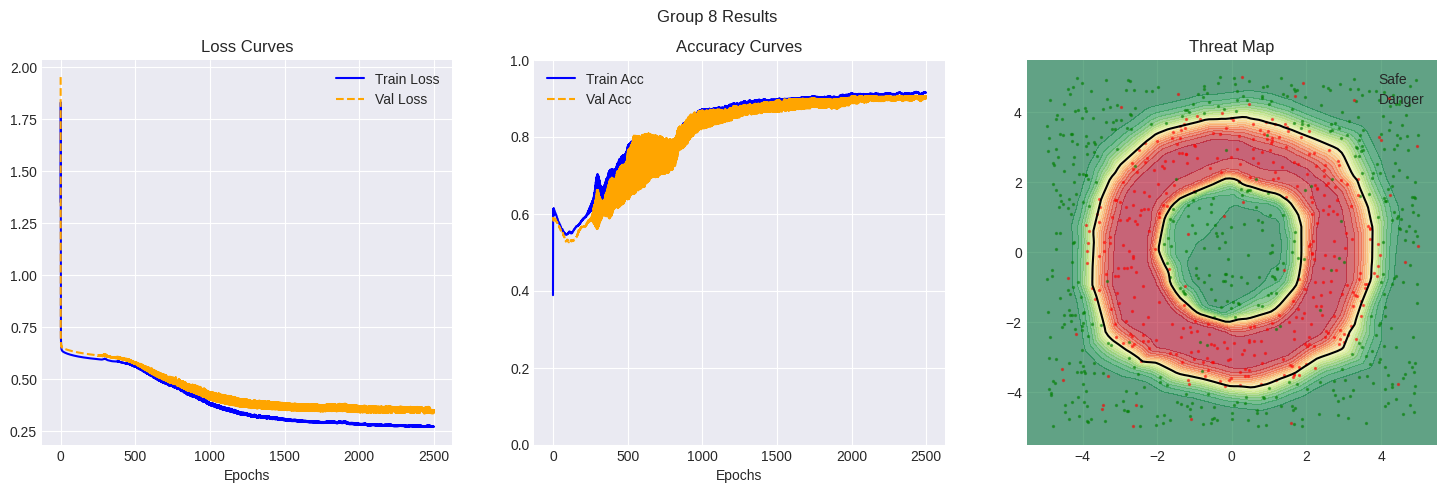

In [17]:
# Setup plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"Group 8 Results")

# Plot 1: Loss
ax[0].plot(train_losses, label='Train Loss', color='blue')
ax[0].plot(val_losses, label='Val Loss', color='orange', linestyle='--')
ax[0].set_title("Loss Curves")
ax[0].set_xlabel("Epochs")
ax[0].legend()

# Plot 2: Accuracy
ax[1].plot(train_accs, label='Train Acc', color='blue')
ax[1].plot(val_accs, label='Val Acc', color='orange', linestyle='--')
ax[1].set_title("Accuracy Curves")
ax[1].set_xlabel("Epochs")
ax[1].set_ylim(0, 1)
ax[1].legend()

# Plot 3: Contour Map
# Create grid
x_span = np.linspace(-5.5, 5.5, 100)
y_span = np.linspace(-5.5, 5.5, 100)
xx, yy = np.meshgrid(x_span, y_span)
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Predict on grid
with torch.no_grad():
    # ERROR FIX: Using 'forward' here to match Part 3 definition
    Z = forward(grid_tensor).reshape(xx.shape)

# Draw contour
ax[2].contourf(xx, yy, Z, levels=20, cmap='RdYlGn_r', alpha=0.6)
ax[2].contour(xx, yy, Z, levels=[0.5], colors='black')

# Scatter plot validation data
safe = X_val[y_val.flatten() == 0]
danger = X_val[y_val.flatten() == 1]

ax[2].scatter(safe[:,0], safe[:,1], c='green', s=2, alpha=0.5, label='Safe')
ax[2].scatter(danger[:,0], danger[:,1], c='red', s=2, alpha=0.5, label='Danger')
ax[2].set_title("Threat Map")
ax[2].legend(loc='upper right')

plt.show()